# Redes generativas adversarias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

## Datos de entrenamiento

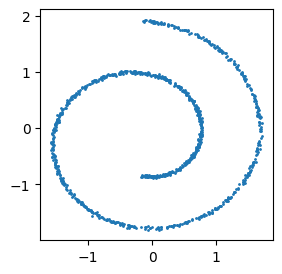

In [2]:
def get_batch(batch_size=1000, noise=0.1):
    x, _ = make_swiss_roll(batch_size, noise=noise)
    x = x[:, [0, 2]]
    x = (x - x.mean()) / x.std()
    return torch.tensor(x).float()

# Ejemplo:
samples = get_batch()
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Redes neuronales

In [3]:
generator = lambda data_dim, latent_dim: nn.Sequential(
    nn.Linear(latent_dim, 32), nn.ReLU(),
    nn.Linear(32, 64), nn.ReLU(),
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, data_dim)
)

discriminator = lambda data_dim: nn.Sequential(
    nn.Linear(data_dim, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 1), nn.Sigmoid()
)

## Entrenamiento

In [4]:
def train(generator, discriminator, latent_dim, iters=5000, batch_fn=get_batch):

    # Optimizadores:
    generator_optimizer = optim.Adam(generator.parameters())
    discriminator_optimizer = optim.Adam(discriminator.parameters())

    for iter in range(iters):
        
        # Datos de entrenamiento:
        x_true = batch_fn()
        x_fake = generator(torch.randn([len(x_true), latent_dim]))

        # Entrenamiento discriminador:
        loss_y1 = torch.log(discriminator(x_true)).mean(dim=0)
        loss_y0 = torch.log(1-discriminator(x_fake.detach())).mean(dim=0)
        loss_discriminator = - 1 / 2 * (loss_y1 + loss_y0)
        discriminator_optimizer.zero_grad()
        loss_discriminator.backward()
        discriminator_optimizer.step()

        # Entrenamiento generador:
        loss_generator = 1 / 2 * torch.log(1-discriminator(x_fake)).mean(dim=0)
        generator_optimizer.zero_grad()
        loss_generator.backward()
        generator_optimizer.step()

In [5]:
data_dim, latent_dim = 2, 16

generator = generator(data_dim, latent_dim)
discriminator = discriminator(data_dim)

train(generator, discriminator, latent_dim)

## Generación

In [6]:
def generate_samples(generator, latent_dim, n_samples=1000):
    z = torch.randn([n_samples, latent_dim])
    samples = generator(z).detach()
    return samples

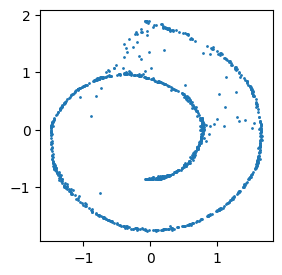

In [7]:
samples = generate_samples(generator, latent_dim)
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()